In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns
import math
from random import shuffle 


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow 
from tensorflow import keras
from keras import Model
from keras.layers import Dense
from keras.layers import Flatten

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.efficientnet import EfficientNetB7

from keras.applications.efficientnet import decode_predictions
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg19 import decode_predictions

from keras.applications.efficientnet import preprocess_input

from keras.preprocessing.image import load_img, img_to_array

import os


from tensorflow.keras import backend as K

os.environ["TF_KERAS"]='1'

import cv2
from PIL import Image 
import glob
import requests
import re

plt.rcParams.update({'figure.max_open_warning': 0})
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("df_tokens",index_col=0)

### Concaténation des features VGG16 + TF-IDF

In [3]:
features_VGG16 = pd.read_csv("VGG_features",index_col=0)

In [4]:
features_TFIDF = pd.read_csv("tfidf_features",index_col=0)

In [5]:
all_features = pd.concat([features_VGG16, features_TFIDF], axis=1)

### Réduction dimentionelle

In [6]:
pca = PCA(n_components=0.99)
all_feat_pca = pca.fit_transform(all_features)

In [7]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80,n_iter=5000, learning_rate=200, random_state=0)

X_tsne_all_ft = tsne.fit_transform(all_feat_pca)

df_tsne_all_ft = pd.DataFrame(X_tsne_all_ft[:,0:2], columns=['tsne1', 'tsne2'])
print(df_tsne_all_ft.shape)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.032s...
[t-SNE] Computed neighbors for 1050 samples in 2.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 32.572598
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.066360
[t-SNE] KL divergence after 2750 iterations: 0.911566
(1050, 2)


In [8]:
def plot_kmeans_tsne(reduction):
    kmeans_tsne = KMeans(n_clusters=7, n_init=50, max_iter=200,init='k-means++', random_state=42).fit(reduction)
    labels_tsne = kmeans_tsne.labels_
    cl_tsne = pd.concat([reduction,pd.DataFrame({'tsne_clusters':labels_tsne})],axis=1)
    
    df['cluster'] = labels_tsne
    categories_predict = df['cluster']
    categories_true = df['pr_product_category_tree']
    adjusted_rand = metrics.adjusted_rand_score(categories_true, categories_predict)
    print("\033[1mAdjusted Rand Index: %0.3f\033[0m" % adjusted_rand)
    
    fig = plt.figure(figsize=(21,8))
    ax = fig.add_subplot(121)

    scatter = sns.scatterplot(x= cl_tsne.iloc[:,0],y = cl_tsne.iloc[:,1], hue = categories_true,
                        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)
    
    plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.01, title='catégories réelles',fontsize='small',fancybox=True)

    plt.title('Représentation selon les vraies classes',fontsize=22)
    
 
    
    ax = fig.add_subplot(122)
    
    scatter = sns.scatterplot(x = cl_tsne.iloc[:,0],y = cl_tsne.iloc[:,1],data = cl_tsne, hue=categories_predict,
                        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    plt.legend(bbox_to_anchor=(0.8, 1), loc=2, borderaxespad=0.01, title='clusters', fontsize='small', fancybox=True)

    plt.title('Représentation selon les clusters',fontsize=22)

            
    return plt.show()

Adjusted Rand Index: 0.442


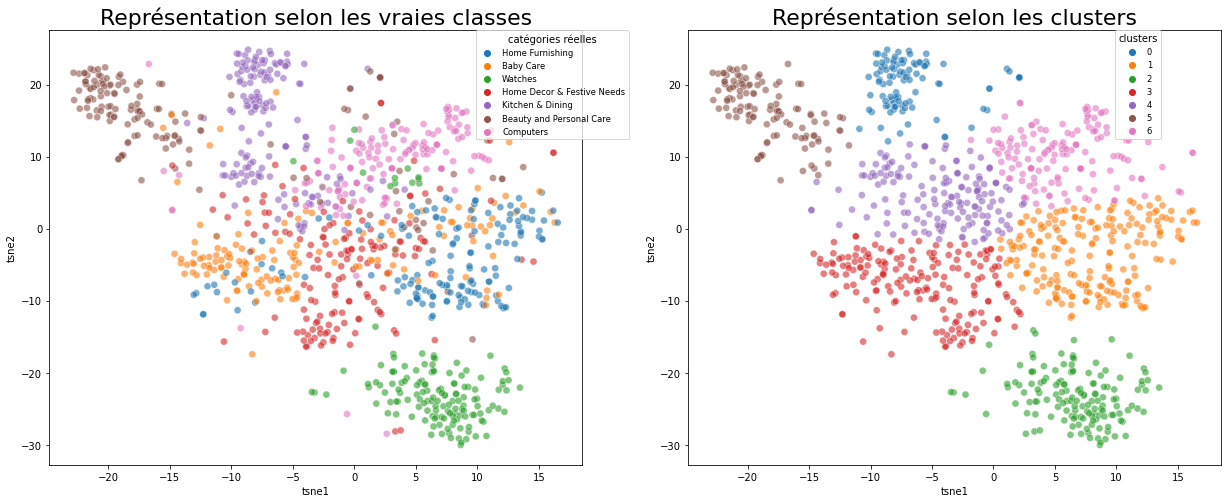

In [9]:
plot_kmeans_tsne(df_tsne_all_ft)

In [63]:
tsne = TSNE(n_components=3, verbose=1, perplexity=80,n_iter=5000, learning_rate=200, random_state=42)

X_tsne_all_ft = tsne.fit_transform(all_feat_pca)

df_tsne_all_ft = pd.DataFrame(X_tsne_all_ft[:,0:3], columns=['tsne1', 'tsne2', 'tsne3'])
print(df_tsne_all_ft.shape)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1050 samples in 0.052s...
[t-SNE] Computed neighbors for 1050 samples in 2.290s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1050
[t-SNE] Computed conditional probabilities for sample 1050 / 1050
[t-SNE] Mean sigma: 32.572598
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.104218
[t-SNE] KL divergence after 5000 iterations: 1.086034
(1050, 3)


In [64]:
kmeans_tsne = KMeans(n_clusters=7, n_init=50, max_iter=200,init='k-means++', random_state=42).fit(df_tsne_all_ft)
labels_tsne = kmeans_tsne.labels_
cl_tsne = pd.concat([df_tsne_all_ft,pd.DataFrame({'tsne_clusters':labels_tsne})],axis=1)
    
df['cluster'] = labels_tsne
categories_predict = df['cluster']
categories_true = df['pr_product_category_tree']
adjusted_rand = metrics.adjusted_rand_score(categories_true, categories_predict)
print("\033[1mAdjusted Rand Index: %0.3f\033[0m" % adjusted_rand)

Adjusted Rand Index: 0.405


In [65]:
fig = px.scatter_3d(df_tsne_all_ft, x='tsne1', y='tsne2', z='tsne3',color=df['pr_product_category_tree'])

fig.update_traces(marker=dict(size=4,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [66]:
fig = px.scatter_3d(df_tsne_all_ft, x='tsne1', y='tsne2', z='tsne3',color=df['cluster'])

fig.update_traces(marker=dict(size=4,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()